In [1]:
import numpy as np 
import pandas as pd
import spacy
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
tqdm_notebook.pandas('Progress')

In [3]:
data = pd.read_csv('./data_clean_1.csv')
data.head().T

,0,1,2,3,4
additional_info,"['TECHNICAL SKILLS\xa0', <br/>, '\xa0', <br/>,...","['TECHNICAL SKILLS:\xa0', <br/>, 'Languages ...","['TECHNICAL SKILLS\xa0', <br/>, '• Proficien...","['TECHNICAL SKILLS\xa0', <br/>, 'Relevant Cour...","['SKILLS\xa0', <br/>, '\xa0', <br/>, 'SOFTWARE..."
rb,NaN,NaN,NaN,NaN,NaN
name,Tracy-Ruan,Sai-Nadimpalli,Nick-Shi,Harsh-Mehta,Daniel-Wu
id,c47f7ac095973653?sp=0,19e0d35744cc56a6?sp=0,accfd33784428f69?sp=0,2a4af24d87cca9cd?sp=0,246fa163d0b35d5b?sp=0
summary_title,Data Scientist Intern,Junior Data Scientist,Data Scientist Intern,Data Scientist,DATA SCIENTIST
location,"San Francisco, CA","Kansas City, MO","Malibu, CA","Bloomington, IN","Brooklyn, NY"
current_job_company,NaN,['Sprint Corporation'],['MarketPsych Data'],['Indiana University'],['MAPSCorps']
current_job_title,Data Scientist Intern,Junior Data Scientist,Data Scientist Intern,Data Scientist,DATA SCIENTIST
current_job_desc,['• Prepared customer behavior datasets for cl...,['• Developed a Hybrid Recommendation System f...,['• Manipulated and interpreted insights fro...,['• Implemented probabilistic character recogn...,['Acted as a Chinese translator when collectin...
current_job_duration,August 2017 to November 2017,May 2017 to August 2017,February 2018 to Present,November 2017 to November 2017,July 2016 to August 2016


In [4]:
skills = data.additional_info.fillna("")
nlp = spacy.load('en')
def clean_up_spacy(text):
    text_out = set()
    clean = re.sub("\s\s+",',',text)
    clean =re.sub("'|•|<br/>","",clean)
    clean =re.sub(r'\w*(?=\\|:)','',clean)
    text = re.sub("xa0|\\\\|:",',',clean)
    text = re.sub("(?<=\w)\s(?=\w+\,)",'_',text)
    text = re.sub("(?<=\w)\s(?=\w+)",'',text)
    text = re.sub(r"\[|]",' ',text)
    text = ' '.join(text.split(','))

    removal1= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','VERB','ADJ','SYM','NOUN','X','NUM','SPACE']
    doc= nlp(text)
    for token in doc:
        
        if token.string == token.string.upper() and len(token)<15 and token.is_punct is False and token.is_alpha: 
            lemma = token.lemma_.strip() 
            text_out.add(lemma)            
        if  token.pos_ not in removal1 and len(token)<15 and token.is_punct is False :
            lemma = token.lemma_.strip()
            if lemma != '':
                text_out.add(lemma)
    text_out = list(text_out)
    return text_out

In [5]:
skillList = skills.progress_apply(lambda x:clean_up_spacy(x))

HBox(children=(IntProgress(value=0, max=12537), HTML(value='')))

In [6]:
finalList =[]
for sublist in skillList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('python', 3845),
 ('r', 3615),
 ('sql', 3545),
 ('java', 2041),
 ('technical', 2030),
 ('c++', 1850),
 ('tableau', 1751),
 ('c', 1747),
 ('sas', 1685),
 ('matlab', 1613)]

## Skill classification using LDA

In [7]:
dictionary = corpora.Dictionary(skillList)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in skillList]

In [8]:
# import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

In [10]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=skillList, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

100%|██████████| 23/23 [10:35<00:00, 27.63s/it]


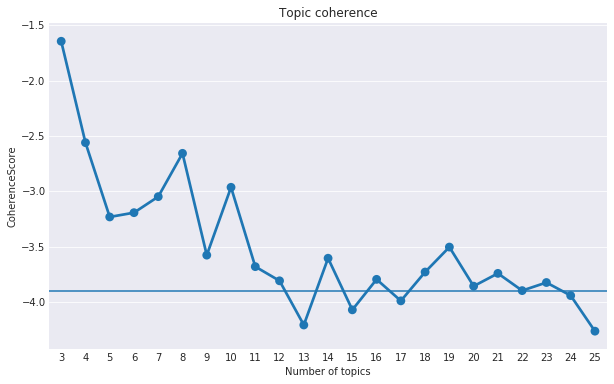

In [12]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

Here I get a sense that the ideal number of topics revolves around 11. I searched the best number of clusters around 11 and found that 12 is the ideal number of clusters.

# Final Model

In [84]:
Lda = models.LdaMulticore
lda_final= Lda(doc_term_matrix, num_topics=12,id2word = dictionary, passes=20,chunksize=4000,random_state=43)

In [86]:
lda_final.save('lda_final')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('doc_term_matrix.mm', doc_term_matrix)